# **A Deep Learning Model for Iceberg Detection at the Amery Ice Shelf, Antarctica**

This research dissertation is submitted
towards the consideration of a degree
in MSc Climate Change,
Department of Geography,
University College London (UCL).

The following code is for the U-Net model used in this study for iceberg detection at the Amery Ice Shelf, Antarctica.

The model is based on the original architecture created by Ronneberger et al. (2015). We modify the model by maintaining the deepest encoder level at 512 channels instead of 1,024 channels with the aim to increase convergence and stability during training and reduce the risk of overfitting.

The model is developed with computational efficiency in mind, with the hope that this model can be used as a lightweight but highly effective Antarctic ice mass monitoring platform.

### The code performs the following:



1.   Defines the classes.
2.   Defines the U-Net model.
3.   Defines the training dataset.
4.   Transforms the data for single-channel and tensor.
5.   Defines training functions.
6.   Defines and runs the training loop.
7.   Same for testing, but using saved model weights for predicted masks.

## **Useful Figures:**

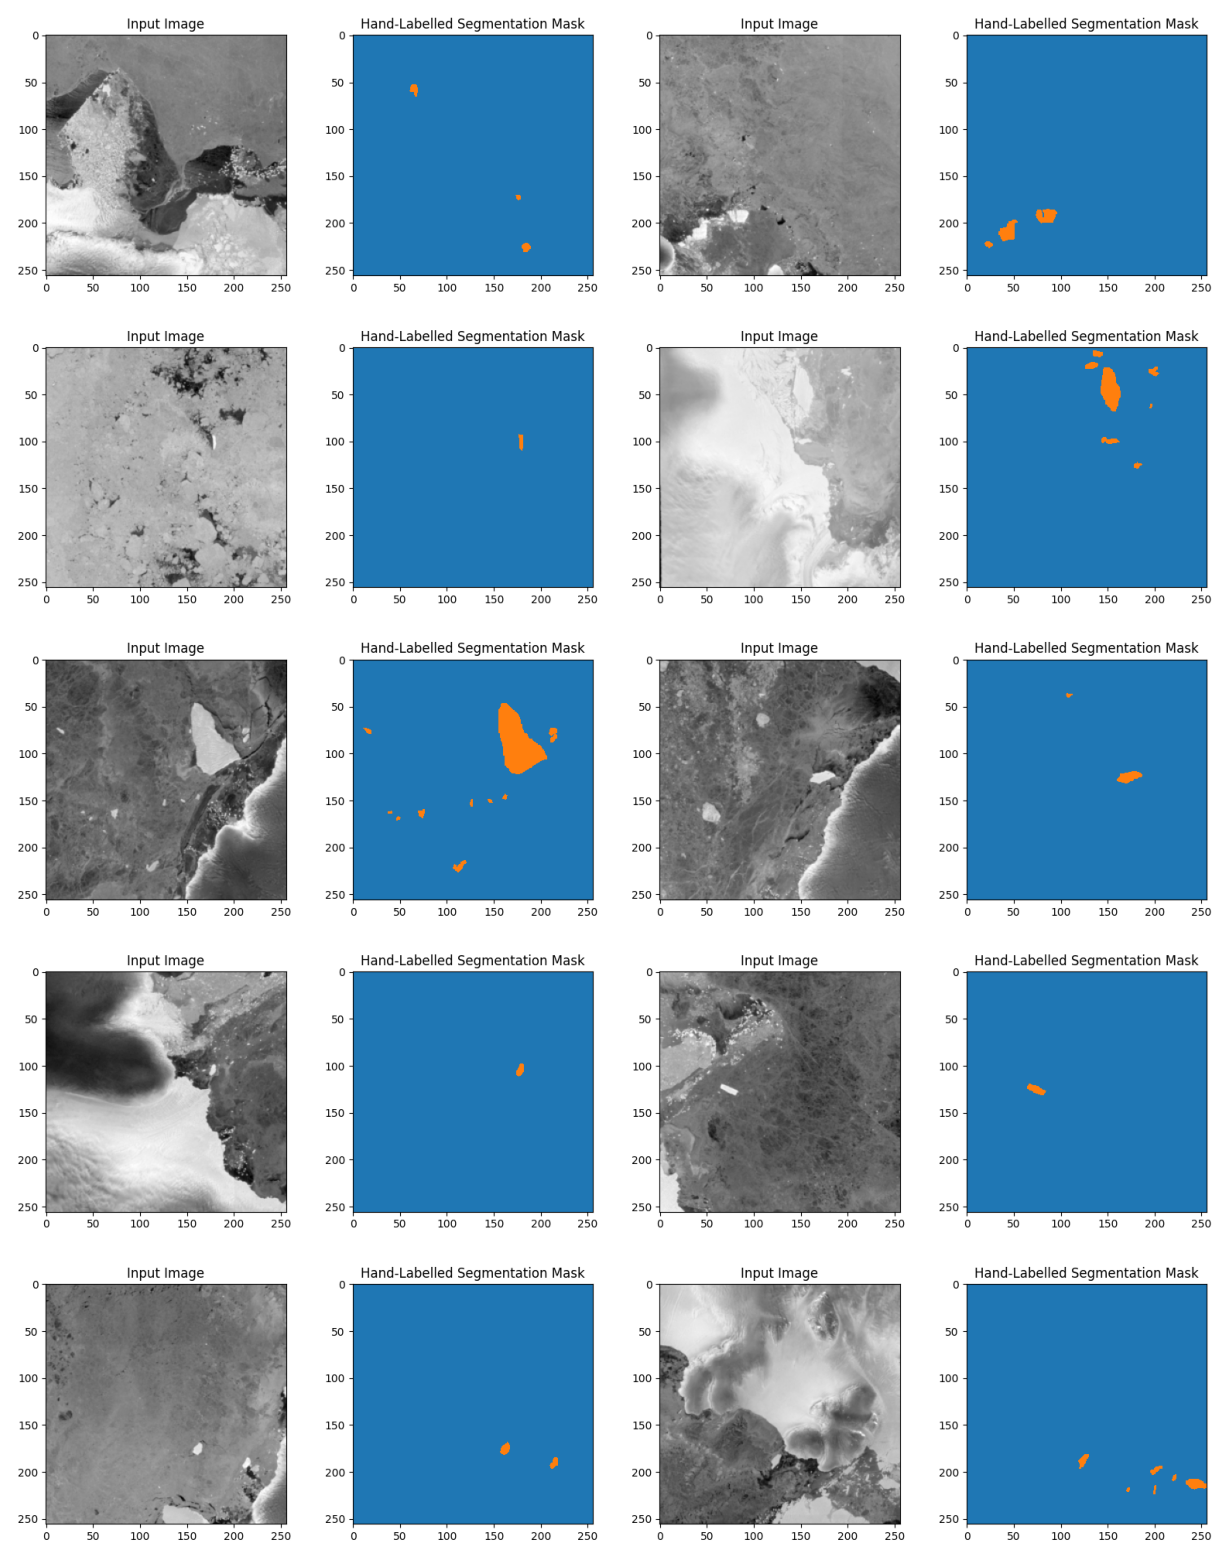

In [ ]:
# Examples of Sentinel-1 SAR input images and their corresponding hand-labelled masks:

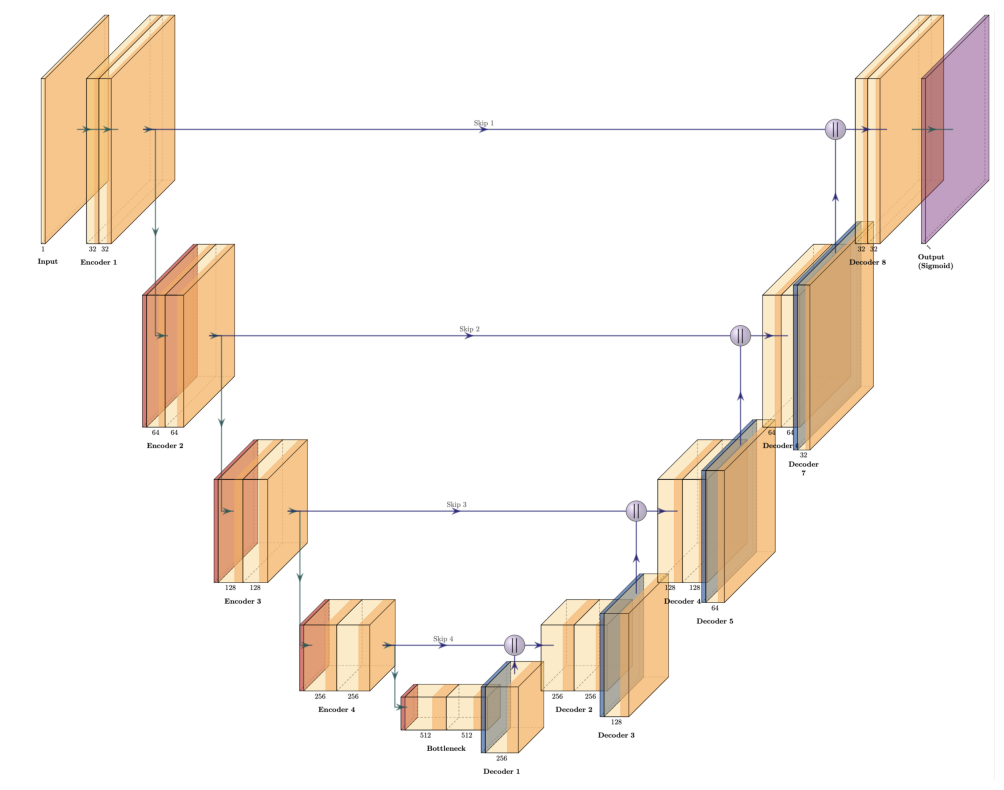

In [ ]:
# The structure of this study's U-Net model. Model structure was created in Latex:

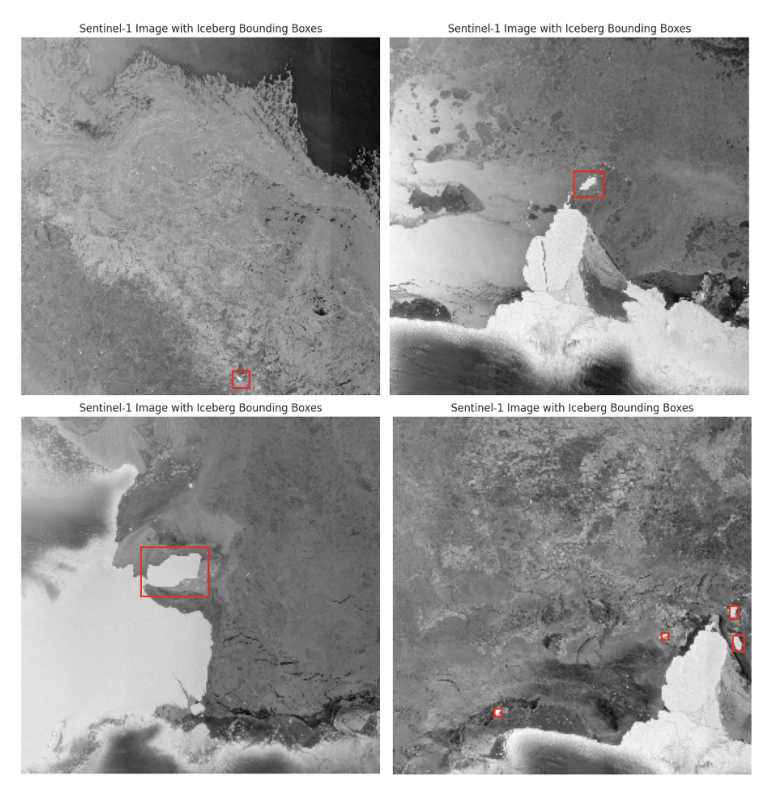

In [ ]:
# Detected icebergs near / at the Amery Ice Shelf across varying scenarios:

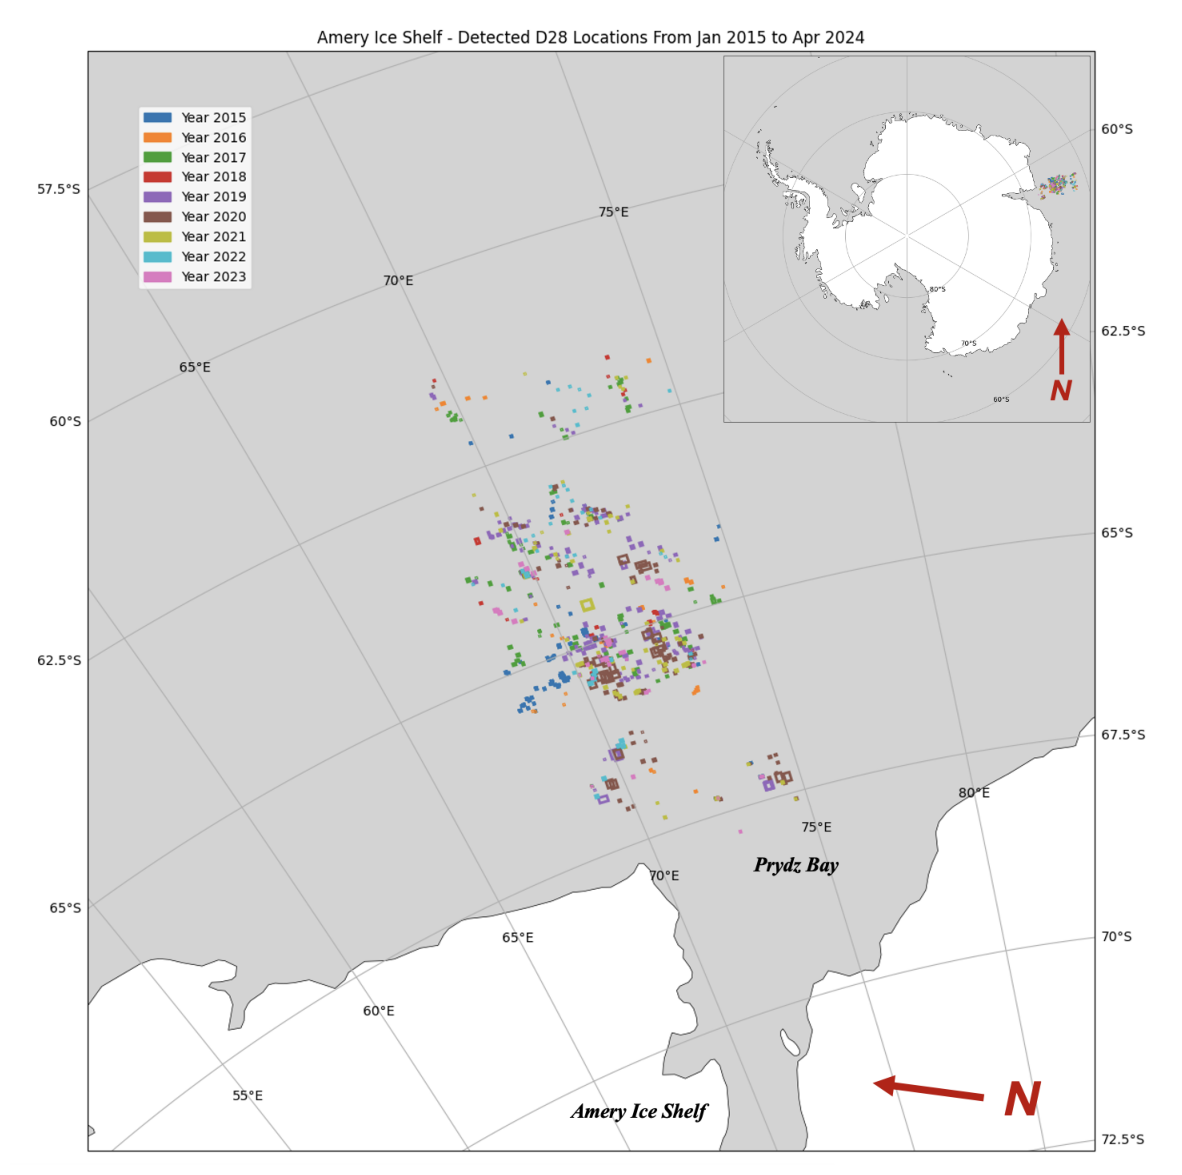

In [ ]:
# The resultant geospatial plot using Cartopy of correctly detected (non-unique) icebergs identified by the U-Net model:

--------------------------------------------------------------------------------

## **Code for Training and Testing the U-Net Model:**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchviz import make_dot
from torchview import draw_graph
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, Subset
from torchmetrics.classification import JaccardIndex
from torchvision import transforms
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

In [ ]:
def map_value_to_class(value):
    if value == 0:
        return 0  # not iceberg
    elif value == 255:
        return 1  # iceberg
    else:
        return 0

## *Training the Model:*

### Building the U-Net:

In [ ]:
class Unet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(Unet, self).__init__()
        channels = [in_channels, 32, 64, 128, 256, 512] # setting highest number of channels to 512
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.conv = nn.Conv2d(channels[1], out_channels, kernel_size=1)

# building the encoder
        for i in range(len(channels)-1):
            if i > 0:
                self.encoder.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.encoder.append(nn.Sequential(
                nn.Conv2d(channels[i], channels[i+1], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(channels[i+1]),
                nn.ReLU(),
                nn.Conv2d(channels[i+1], channels[i+1], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(channels[i+1]),
                nn.ReLU()
            ))

# building the decoder
        channels = channels[1:]
        channels = channels[::-1]
        for i in range(len(channels)-1):
            self.decoder.append(nn.ConvTranspose2d(channels[i], channels[i+1], kernel_size=2, stride=2))
            self.decoder.append(nn.Sequential(
                nn.Conv2d(channels[i], channels[i+1], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(channels[i+1]),
                nn.ReLU(),
                nn.Conv2d(channels[i+1], channels[i+1], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(channels[i+1]),
                nn.ReLU()
            ))

# building the skip connections
    def forward(self, x):
        skips = []
        for i in range(len(self.encoder)):
            x = self.encoder[i](x)
            if i % 2 == 0:
                skips.append(x)

        skips = skips[:-1]
        skips = skips[::-1]
        for i in range(len(self.decoder)):
            if i % 2 == 1:
                skip = transforms.CenterCrop(x.shape[2:])(skips[i//2])
                x = torch.cat((skip, x), dim=1)
            x = self.decoder[i](x)

# output layer
        return self.conv(x)  # single channel output for binary classification

### Defining the Dataset:

In [ ]:
class IceData(Dataset):
    def __init__(self, dataset_path, transform=None, mask_transform=None):
        self.images_path = os.path.join(dataset_path, "images")
        self.targets_path = os.path.join(dataset_path, "masks")

        self.images_list = sorted([f for f in os.listdir(self.images_path) if f.endswith('.tif')])
        self.targets_list = sorted([f for f in os.listdir(self.targets_path) if f.endswith('.png')])

        # only image-mask pairs used
        self.images_list = [f for f in self.images_list if os.path.splitext(f)[0] in {os.path.splitext(t)[0] for t in self.targets_list}]
        self.targets_list = [f for f in self.targets_list if os.path.splitext(f)[0] in {os.path.splitext(i)[0] for i in self.images_list}]

        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, i):
        image_path = os.path.join(self.images_path, self.images_list[i])
        target_path = os.path.join(self.targets_path, self.targets_list[i])

        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")
        if not os.path.exists(target_path):
            raise FileNotFoundError(f"Target file not found: {target_path}")

        try:
            image = tiff.imread(image_path)
        except Exception as e:
            raise ValueError(f"Failed to load image: {image_path}. Error: {e}")

        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)

        target = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)
        if target is None:
            raise ValueError(f"Failed to load target: {target_path}")
        target = np.expand_dims(target, axis=-1)

        # apply map func to convert mask values to class labels
        target_class = np.vectorize(map_value_to_class)(target).astype(np.uint8)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            target_class_pil = Image.fromarray(target_class.squeeze())
            target_class_resized = target_class_pil.resize((256, 256), Image.NEAREST)
            target_class_resized = np.array(target_class_resized).astype(np.uint8)
            target_class_tensor = torch.tensor(target_class_resized, dtype=torch.long)
            target_class = target_class_tensor

        return image, target_class

In [ ]:
# Image transformation
image_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),  # single-channel images only
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Use the same mask transform as defined above
mask_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.Lambda(lambda img: np.array(img, dtype=np.uint8)),  # making sure mask is ndarray
    transforms.Lambda(lambda img: np.vectorize(map_value_to_class)(img).astype(np.uint8)),  # mapping values corresponding with class labels
    transforms.Lambda(lambda img: torch.tensor(img, dtype=torch.long))  # converting to tensor and long type
])

### Defining Dataset Path, Training Data and Split:

In [ ]:
# dataset master
dataset_path = "..../train"
dataset = IceData(dataset_path, transform=image_transform, mask_transform=mask_transform)

In [ ]:
image_folder = '..../images'
mask_folder = '..../masks'

In [ ]:
# splitting dataset into train and validation
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=32) # 80:20 train:valid spit
trainset = Subset(dataset, train_indices)
testset = Subset(dataset, test_indices)

print(f"Number of training images: {len(trainset)}")
print(f"Number of validation images: {len(testset)}")

# verifying split has been performed
print("First 5 training image files:")
for idx in train_indices[:5]:
    print(dataset.images_list[idx])

print("First 5 test image files:")
for idx in test_indices[:5]:
    print(dataset.images_list[idx])

### Defining Model Parameters:

In [ ]:
# dataloader
batch_size = 16
pin_memory = True if torch.cuda.is_available() else False
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=os.cpu_count())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory, num_workers=os.cpu_count())

In [ ]:
# define device to ensure using gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device being used: {device}.")

In [ ]:
# epochs and learning rate (hyperparameters)
epochs = 50
lr = 0.001

In [ ]:
# initialising model
# defining loss function, optimiser, and learning rate scheduler
model = Unet(in_channels=1, out_channels=1)  # binary classification
model = model.to(device=device)

criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device=device)

optimizer = optim.Adam(model.parameters(), lr=lr)
lr_decay = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

metric = JaccardIndex(task='binary').to(device)

### Training Loop:

In [ ]:
# storing data for training visualisation figures
all_train_losses = []
all_test_losses = []
all_accuracies = []
epoch_train_preds = []
epoch_test_preds = []
epoch_train_targets = []
epoch_test_targets = []

# storing results as a dataframe
results_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Validation Loss', 'Accuracy'])

# Training and evaluation loop
start_time = time.time()
train_loss = []
test_loss = []
best_loss = float('inf')
best_model_path = '....HL_run3.pth' # saving model weights (HL_run3 is the best model weights from the U-Net Model)

# setting a callback function to stop training if no improvement in validation loss over 3 epochs
patience = 3
no_improvement_counter = 0

# training loop
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    running_accuracy = 0.0
    for images, targets in tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch}/{epochs} - Training'):
        images = images.to(device)
        targets = targets.to(device).float()  # ensuring targets are floats

        optimizer.zero_grad()
        preds = model(images)
        targets = targets.unsqueeze(1)  # adding channel dimension to targets
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # storing preds and targets for visualisation
        epoch_train_preds.append(preds.detach().cpu().numpy())
        epoch_train_targets.append(targets.detach().cpu().numpy())

    train_loss_epoch = running_train_loss / len(train_loader)
    train_loss.append(train_loss_epoch)
    all_train_losses.append(train_loss_epoch)

    model.eval()
    running_test_loss = 0.0
    running_accuracy = 0.0
    with torch.no_grad():
        for images, targets in tqdm(test_loader, total=len(test_loader), desc=f'Epoch {epoch}/{epochs} - Validation'):
            images = images.to(device)
            targets = targets.to(device).float()

            preds = model(images)
            targets = targets.unsqueeze(1)
            loss = criterion(preds, targets)

            running_test_loss += loss.item()

            # converting logits to probabilities then to binary pred
            preds_binary = (torch.sigmoid(preds) > 0.5).float()
            running_accuracy += metric(preds_binary, targets)

            # storing preds and targets for visualisation
            epoch_test_preds.append(preds.detach().cpu().numpy())
            epoch_test_targets.append(targets.detach().cpu().numpy())

    test_loss_epoch = running_test_loss / len(test_loader)
    test_loss.append(test_loss_epoch)
    all_test_losses.append(test_loss_epoch)
    accuracy = running_accuracy / len(test_loader)
    all_accuracies.append(accuracy)

    # saving results for this epoch to a dataframe
    epoch_data = pd.DataFrame({
        'Epoch': [epoch + 1],
        'Train Loss': [train_loss_epoch],
        'Validation Loss': [test_loss_epoch],
        'Accuracy': [accuracy.item()]
    })

    results_df = pd.concat([results_df, epoch_data], ignore_index=True)

    if test_loss_epoch < best_loss:
        best_loss = test_loss_epoch
        torch.save(model.state_dict(), best_model_path)
        print("Model saved!")
        no_improvement_counter = 0  # reset counter if the validation loss improves
    else:
        no_improvement_counter += 1  # increment counter if no improvement

    # checking for early stop
    if no_improvement_counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

    lr_decay.step()
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss[-1]:.4f}, Validation Loss: {test_loss[-1]:.4f}, Accuracy: {accuracy:.4f}")

print(f"Finished Training. Best loss: {best_loss:.4f}")
print("Total time: {} minutes.".format(round((time.time() - start_time)/60, 2)))

# saving best model weights
torch.save(model.state_dict(), best_model_path)

# saving dataframe with training stats to .csv
results_df.to_csv('..../HL_train_results3.csv', index=False)

print("Training results saved to .csv file.")

## *Testing the Model:*

This section had to be run with a new instance of Colab due to the GPU memory not being "rest" after training. This caused problems with placing model weights on the GPU for testing - a problem as we used a GPU for training beforehand.

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchmetrics.classification import BinaryJaccardIndex, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryConfusionMatrix
import tifffile
import numpy as np
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

In [ ]:
def map_value_to_class(value):
    if value == 0:
        return 0  # not iceberg
    elif value == 255:
        return 1  # iceberg
    else:
        return 0

In [ ]:
# same U-Net code in training section
class Unet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(Unet, self).__init__()
        channels = [in_channels, 32, 64, 128, 256, 512]
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.conv = nn.Conv2d(channels[1], out_channels, kernel_size=1)

        for i in range(len(channels) - 1):
            if i > 0:
                self.encoder.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.encoder.append(nn.Sequential(
                nn.Conv2d(channels[i], channels[i + 1], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(channels[i + 1]),
                nn.ReLU(),
                nn.Conv2d(channels[i + 1], channels[i + 1], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(channels[i + 1]),
                nn.ReLU()
            ))

        channels = channels[1:]
        channels = channels[::-1]
        for i in range(len(channels) - 1):
            self.decoder.append(nn.ConvTranspose2d(channels[i], channels[i + 1], kernel_size=2, stride=2))
            self.decoder.append(nn.Sequential(
                nn.Conv2d(channels[i], channels[i + 1], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(channels[i + 1]),
                nn.ReLU(),
                nn.Conv2d(channels[i + 1], channels[i + 1], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(channels[i + 1]),
                nn.ReLU()
            ))

    def forward(self, x):
        skips = []
        for i in range(len(self.encoder)):
            x = self.encoder[i](x)
            if i % 2 == 0:
                skips.append(x)

        skips = skips[:-1]
        skips = skips[::-1]
        for i in range(len(self.decoder)):
            if i % 2 == 1:
                skip = transforms.CenterCrop(x.shape[2:])(skips[i // 2])
                x = torch.cat((skip, x), dim=1)
            x = self.decoder[i](x)

        return self.conv(x)

In [ ]:
class IceData(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.images_path = os.path.join(dataset_path, "images")
        self.targets_path = os.path.join(dataset_path, "masks")

        self.images_list = sorted([f for f in os.listdir(self.images_path) if f.endswith('.tif')])
        self.targets_list = sorted([f for f in os.listdir(self.targets_path) if f.endswith('.png')])

        self.images_list = [f for f in self.images_list if f.replace('.tif', '.png') in self.targets_list]
        self.targets_list = [f for f in self.targets_list if f.replace('.png', '.tif') in self.images_list]

        self.transform = transform

        print(f"Found {len(self.images_list)} image-mask pairs")

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_path, self.images_list[idx])
        target_path = os.path.join(self.targets_path, self.targets_list[idx])

        image = tifffile.imread(image_path)

        image = (image - image.min()) / (image.max() - image.min()) * 255
        image = image.astype(np.uint8)

        image = Image.fromarray(image).convert('L')
        if self.transform:
            image = self.transform(image)

        target = Image.open(target_path).convert('L')
        target = target.resize((256, 256), Image.NEAREST)
        target = np.array(target)
        target = np.vectorize(map_value_to_class)(target).astype(np.uint8)
        target = torch.tensor(target, dtype=torch.float32)

        return image, target, os.path.splitext(self.images_list[idx])[0]

### Testing the Model on the Amery Dataset (50 samples):

In [ ]:
# test dataset
dataset_path = "..../test"
test_dataset = IceShelfDatasetTest(dataset_path, transform=transform)

In [ ]:
# dataloader
batch_size = 1
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

# ensure valid data
if len(test_loader) == 0:
    raise ValueError("No valid image-mask pairs found in the test dataset.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device being used: {device}.")

In [ ]:
# loading model weights
model_path = "..../HL_run3.pth"
model = Unet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load(model_path, map_location=device))  # load model weights
model = model.to(device=device)  # moving the model to the correct device (cuda)

In [ ]:
# loss function and metric
criterion = nn.BCEWithLogitsLoss()  # binary cross entropy
criterion = criterion.to(device=device)

In [ ]:
# saving predicted masks at 256 x 256 pixels to output folder
output_dir = "..../HL_run3_testpred_masks"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# calculating for class-weighted metrics

from collections import defaultdict

class_counts = defaultdict(int)

for idx, (images, targets, image_name) in tqdm(enumerate(test_loader), total=len(test_loader), desc='Calculating Class Imbalance'):
    # flat target masks to count class occurrences
    targets_flat = targets.cpu().numpy().flatten()

    class_counts[0] += (targets_flat == 0).sum()  # class 0 (not iceberg)
    class_counts[1] += (targets_flat == 1).sum()  # class 1 (iceberg)

# ratio of class0:class1
if class_counts[1] != 0:
    class_ratio = class_counts[0] / class_counts[1]
else:
    class_ratio = float('inf')

print(f"Class 0 (background) to Class 1 (iceberg) ratio: {class_ratio:.2f}")
print(f"Class 0 count: {class_counts[0]}")
print(f"Class 1 count: {class_counts[1]}")

### Testing Loop:

In [ ]:
start_time = time.time()
test_preds = []
all_targets = []
all_probs_list = []  # storing probabilities for roc etc.

with torch.no_grad():
    accuracy = 0
    model.eval()  # model in evaluate mode
    for idx, (images, targets, image_name) in tqdm(enumerate(test_loader), total=len(test_loader), desc='Testing'):
        try:
            images = images.to(device)
            targets = targets.to(device).unsqueeze(1)

            # Forward pass
            preds = model(images)
            loss = criterion(preds, targets)

            probs = torch.sigmoid(preds)
            preds_binary = (probs > 0.5).float()

            # collecting preds and targets for post test
            test_preds.append(preds_binary.cpu())
            all_targets.append(targets.cpu())
            all_probs_list.append(probs.cpu())

            # saving predicted mask as single-channel .png
            pred_np = preds_binary.cpu().numpy().squeeze()
            pred_mask = (pred_np * 255).astype(np.uint8)
            pred_image = Image.fromarray(pred_mask, mode='L')
            image_name_str = image_name if isinstance(image_name, str) else image_name[0]
            pred_image.save(os.path.join(output_dir, f"{image_name_str}.png"))  # saving pred mask with original image filename

        except UnidentifiedImageError as e:
            print(f"Skipping file {image_name_str} due to error: {e}")

# converting all test preds and targets to single tensor after test loop
all_preds = torch.cat(test_preds).to(device)
all_targets = torch.cat(all_targets).to(device)
all_probs = torch.cat(all_probs_list).cpu().numpy()
all_targets_np = all_targets.cpu().numpy()

# class-weighted precision, recall, f1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_targets_np.flatten(), all_preds.cpu().numpy().flatten(), average='binary')

# confusion matrix
conf_matrix = confusion_matrix(all_targets_np.flatten(), all_preds.cpu().numpy().flatten())

print(f"Finished Testing. Accuracy (IoU): {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Class-Weighted Precision: {precision:.4f}")
print(f"Class-Weighted Recall: {recall:.4f}")
print(f"Class-Weighted F1 Score: {f1:.4f}")
print("Total time: {} minutes.".format(round((time.time() - start_time)/60, 2)))

In [ ]:
# plotting input image, ground truth (hand labelled), and predicted mask

from matplotlib.colors import ListedColormap

cmap = ListedColormap(['#1f77b4', '#ff7f0e'])  # blue for class 0, orange for class 1

def plot_dataset(dataset, test_preds, n_images=None, file_name="DatasetPlot"):
    if n_images is None:
        n_images = len(dataset)

    fig, axes = plt.subplots(n_images, 3, figsize=(10, 2 * n_images))

    if n_images == 1:
        axes = [axes]

    for idx, (image, target, image_name) in enumerate(dataset):
        if idx >= n_images:
            break

        image_np = np.array(image.permute(1, 2, 0))
        target_np = target.numpy()

        axes[idx][0].imshow(image_np, cmap='gray')
        axes[idx][0].set_title("Input Image")
        axes[idx][0].axis('off')

        im = axes[idx][1].imshow(target_np, cmap=cmap, vmin=0, vmax=1)
        axes[idx][1].set_title("Ground Truth")
        axes[idx][1].axis('off')

        if len(test_preds) > idx:
            pred_np = test_preds[idx].numpy().squeeze()
            im_pred = axes[idx][2].imshow(pred_np, cmap=cmap, vmin=0, vmax=1)
            axes[idx][2].set_title("Prediction")
            axes[idx][2].axis('off')
        else:
            im_pred = axes[idx][2].imshow(np.zeros_like(image_np))
            axes[idx][2].set_title("Prediction")
            axes[idx][2].axis('off')

    cbar = fig.colorbar(im_pred, ax=axes[:, 2], orientation='vertical', fraction=0.02, pad=0.5)
    cbar.set_label('Class Label')
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Class 0', 'Class 1'])

    plt.tight_layout()
    plt.savefig(f"{file_name}.png")
    plt.show()

# number of test images to plot
n_test_images_to_plot = 50
# export all pred plots
plot_dataset(test_dataset, test_preds, n_images=n_test_images_to_plot, file_name="TestDataPlot")